Сначала как-то рандомно скачиваю архив и распаковываю его для тестирования

In [ ]:
!wget https://sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru:443/wildlife_project/whale_leus/Whale%20ReId%202.7z

--2025-03-29 04:02:09--  https://sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru/wildlife_project/whale_leus/Whale%20ReId%202.7z
Resolving sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru (sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru)... 46.243.206.34, 46.243.206.35
Connecting to sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru (sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru)|46.243.206.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7624464497 (7.1G) [application/x-7z-compressed]
Saving to: ‘Whale ReId 2.7z’

Whale ReId 2.7z     100%[===================>]   7.10G  31.3MB/s    in 4m 3s   

2025-03-29 04:06:13 (29.9 MB/s) - ‘Whale ReId 2.7z’ saved [7624464497/7624464497]



In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 26.7 MB/s eta 0:00:00


In [ ]:
import py7zr
import os

with py7zr.SevenZipFile('/content/Whale ReId 2.7z', mode='r') as archive:
    all_files = archive.getnames()

In [ ]:
archive_path = "/content/Whale ReId 2.7z"
extract_dir = "/content/Whales"

os.makedirs(extract_dir, exist_ok=True)

with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=extract_dir)

In [ ]:
!find /content/Whales -type f -name "*.png" -delete

In [ ]:
import shutil
from tqdm import tqdm
import random

def split_whale_data(source_dir, train_ratio=0.8):
    whales = os.listdir(source_dir)
    for whale in tqdm(whales):
        whale_path = os.path.join(source_dir, whale)
        dates = os.listdir(whale_path)
        random.shuffle(dates)

        total_photos = sum(
            len(os.listdir(os.path.join(whale_path, date)))
            for date in dates
        )
        target_test_photos = int(total_photos * (1 - train_ratio))

        train_dates, test_dates = [], []
        test_photo_count = 0

        for date in dates:
            date_photos = len(os.listdir(os.path.join(whale_path, date)))
            if test_photo_count + date_photos <= target_test_photos:
                test_dates.append(date)
                test_photo_count += date_photos
            else:
                train_dates.append(date)

        if not test_dates:
            test_dates = [random.choice(dates)]
            train_dates = [d for d in dates if d not in test_dates]

        for date in train_dates:
            src = os.path.join(whale_path, date)
            dst = os.path.join("whales_processed/train", whale, date)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copytree(src, dst)

        for date in test_dates:
            src = os.path.join(whale_path, date)
            dst = os.path.join("whales_processed/test", whale, date)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copytree(src, dst)

split_whale_data("/content/Whales/Whale ReId 2")

100%|██████████| 102/102 [01:47<00:00,  1.05s/it]


In [ ]:
def check_balance(root_dir, min_train_percent=70, max_train_percent=90):
    stats = {}
    deleted_whales = []

    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in os.listdir(split_path):
            if whale not in stats:
                stats[whale] = {"train": {"photos": 0, "dates": 0},
                               "test": {"photos": 0, "dates": 0}}

            whale_path = os.path.join(split_path, whale)
            photo_count = 0
            date_count = 0

            for date in os.listdir(whale_path):
                date_path = os.path.join(whale_path, date)
                if os.path.isdir(date_path):
                    date_count += 1
                    photos = [f for f in os.listdir(date_path)
                             if f.lower().endswith(('.jpg'))]
                    photo_count += len(photos)

            stats[whale][split]["photos"] = photo_count
            stats[whale][split]["dates"] = date_count

    for whale, data in stats.copy().items():
        total = data["train"]["photos"] + data["test"]["photos"]
        if total == 0:
            del stats[whale]
            continue

        train_percent = (data["train"]["photos"] / total) * 100

        if not (min_train_percent <= train_percent <= max_train_percent):
            for split in ["train", "test"]:
                whale_path = os.path.join(root_dir, split, whale)
                if os.path.exists(whale_path):
                    shutil.rmtree(whale_path)

            deleted_whales.append(whale)
            del stats[whale]

    # Вывод статистики
    print("\n{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "Кит", "Train фото", "Test фото", "Train %", "Test %", "Даты (train/test)"))
    print("-" * 70)

    for whale, data in stats.items():
        total = data["train"]["photos"] + data["test"]["photos"]
        train_p = (data["train"]["photos"] / total) * 100
        test_p = (data["test"]["photos"] / total) * 100

        print("{:<15} {:<10} {:<10} {:<10.1f}% {:<10.1f}% {:<10}".format(
            whale,
            data["train"]["photos"],
            data["test"]["photos"],
            train_p,
            test_p,
            f"{data['train']['dates']}/{data['test']['dates']}"
        ))

    # Вывод удаленных папок
    if deleted_whales:
        print("\nУдаленные папки с плохим балансом:")
        for whale in deleted_whales:
            print(f"- {whale}")
    else:
        print("\nВсе папки соответствуют балансу!")

# Пример использования
check_balance("whales_processed", min_train_percent=70, max_train_percent=90)


Кит             Train фото Test фото  Train %    Test %     Даты (train/test)
----------------------------------------------------------------------
21_34_frames    331        39         89.5      % 10.5      % 3/3       
21_35_frames    94         19         83.2      % 16.8      % 4/3       
20_51_frames    97         23         80.8      % 19.2      % 3/1       
20_53_frames    848        96         89.8      % 10.2      % 3/1       
21_38_frames    149        25         85.6      % 14.4      % 7/2       
21_42_frames    322        38         89.4      % 10.6      % 1/1       
20_21_frames    715        103        87.4      % 12.6      % 2/3       
20_25_frames    385        96         80.0      % 20.0      % 5/2       
20_02_frames    133        24         84.7      % 15.3      % 4/1       
22_04_frames    99         20         83.2      % 16.8      % 2/3       
20_43_frames    442        101        81.4      % 18.6      % 4/3       
22_01_frames    458        108        80.9     

In [ ]:
def flatten_directory_structure(root_dir):
    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in tqdm(os.listdir(split_path), desc=f"Processing {split}"):
            whale_path = os.path.join(split_path, whale)

            for root, dirs, files in os.walk(whale_path):
                for file in files:
                    if file.lower().endswith(('.jpg')):
                        src_path = os.path.join(root, file)

                        date_folder = os.path.basename(root)
                        new_filename = f"{date_folder}_{file}"

                        dest_path = os.path.join(whale_path, new_filename)

                        shutil.move(src_path, dest_path)

            for root, dirs, files in os.walk(whale_path, topdown=False):
                for dir in dirs:
                    dir_path = os.path.join(root, dir)
                    if not os.listdir(dir_path):
                        os.rmdir(dir_path)

flatten_directory_structure("whales_processed")

Processing test: 100%|██████████| 63/63 [00:00<00:00, 220.25it/s]


In [ ]:
def keep_common_folders(dataset_path, max_folders_to_keep=5):
    """Оставляет только указанное количество общих папок в train/test"""
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test")

    train_folders = set(os.listdir(train_path)) if os.path.exists(train_path) else set()
    test_folders = set(os.listdir(test_path)) if os.path.exists(test_path) else set()

    common_folders = list(train_folders & test_folders)
    print(f"Найдено общих папок: {len(common_folders)}")

    if len(common_folders) < max_folders_to_keep:
        print(f"Внимание: доступно только {len(common_folders)} общих папок")
        max_folders_to_keep = len(common_folders)

    folders_to_keep = random.sample(common_folders, max_folders_to_keep)
    print(f"Сохраняем папки: {', '.join(folders_to_keep)}")

    if os.path.exists(train_path):
        for folder in tqdm(os.listdir(train_path), desc="Обработка train"):
            if folder not in folders_to_keep:
                shutil.rmtree(os.path.join(train_path, folder))
    if os.path.exists(test_path):
        for folder in tqdm(os.listdir(test_path), desc="Обработка test"):
            if folder not in folders_to_keep:
                shutil.rmtree(os.path.join(test_path, folder))

dataset_path = "whales_processed"
keep_common_folders(
    dataset_path=dataset_path,
    max_folders_to_keep=10
)

Найдено общих папок: 63
Сохраняем папки: 22_08_frames, 20_67_frames, 21_34_frames, 20_31_frames, 20_02_frames, 20_21_frames, 20_55_frames, 21_37_frames, 21_40_frames, 20_51_frames


Обработка test: 100%|██████████| 63/63 [00:00<00:00, 309.15it/s]


### Далее начинается работа с предсказаниями

In [ ]:
!pip install faiss-gpu-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
import os
import faiss
import numpy as np
import torch
import timm
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "whales_processed"
MODEL_NAME = "hf-hub:BVRA/MegaDescriptor-L-384"
IMAGE_SIZE = 384

model = timm.create_model(MODEL_NAME, pretrained=True).to(DEVICE)
model.eval()

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
def get_embedding(image_path):
    """Получение эмбеддинга для одного изображения"""
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = model(tensor)
    return features.cpu().numpy().flatten()

In [ ]:
def build_faiss_index(folder_path):
    """Построение FAISS индекса"""
    embeddings = []
    paths = []

    for root, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=f"Обработка {os.path.basename(root)}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                emb = get_embedding(path)
                if emb is not None:
                    embeddings.append(emb)
                    paths.append(path)

    dimension = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dimension)
    index.add(np.array(embeddings).astype('float32'))

    return index, paths

In [ ]:
def search_similar(query_path, index, paths, k=5):
    """Поиск похожих изображений"""
    query_emb = get_embedding(query_path)
    if query_emb is None:
        return []

    distances, indices = index.search(np.array([query_emb]).astype('float32'), k)
    return [(paths[i], distances[0][j]) for j, i in enumerate(indices[0])]

In [ ]:
import matplotlib.pyplot as plt

def show_results(query_path, results):
    """Визуализация найденных изображений"""
    plt.figure(figsize=(15,5))

    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query Image")

    for i, (path, distance) in enumerate(results, 1):
        plt.subplot(1, 6, i+1)
        plt.imshow(Image.open(path))
        plt.title(f"#{i}\n{distance:.2f}")

    plt.tight_layout()
    plt.show()

In [ ]:
train_index, train_paths = build_faiss_index(os.path.join(DATA_PATH, "train"))

Обработка train: 0it [00:00, ?it/s]
Обработка 21_37_frames: 100%|██████████| 78/78 [07:14<00:00,  5.57s/it]



Топ-5 похожих изображений:
crop4_DJI_0130_crop4_DJI_0130_83.jpg (расстояние: 56.75)
crop4_DJI_0130_crop4_DJI_0130_90.jpg (расстояние: 63.37)
crop4_DJI_0130_crop4_DJI_0130_68.jpg (расстояние: 64.15)
crop4_DJI_0130_crop4_DJI_0130_75.jpg (расстояние: 64.92)
crop4_DJI_0130_crop4_DJI_0130_60.jpg (расстояние: 74.78)


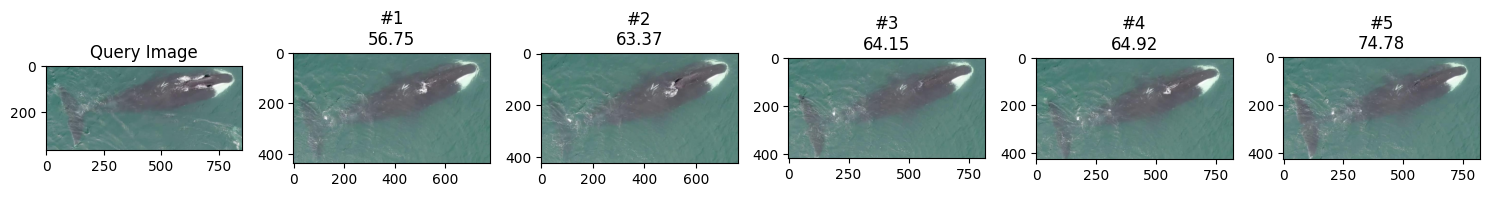

In [ ]:
test_image = os.path.join(DATA_PATH, "test", "20_02_frames", "crop3_DJI_0130_crop3_DJI_0130_1.jpg")
results = search_similar(test_image, train_index, train_paths)

print("\nТоп-5 похожих изображений:")
for path, distance in results:
    print(f"{os.path.basename(path)} (расстояние: {distance:.2f})")
show_results(test_image, results)

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns

def evaluate_model(test_folder, index, paths, k_values=(1, 5)):
    """Расширенная оценка модели с несколькими метриками"""
    y_true = []
    y_pred = []
    all_scores = {k: [] for k in k_values}

    for root, _, files in os.walk(test_folder):
        for file in tqdm(files, desc="Оценка модели"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                query_path = os.path.join(root, file)
                true_label = os.path.basename(root)

                results = search_similar(query_path, index, paths, k=max(k_values))
                if not results:
                    continue

                retrieved_labels = [os.path.basename(os.path.dirname(p[0])) for p in results]
                for k in k_values:
                    all_scores[k].append(1 if true_label in retrieved_labels[:k] else 0)

                pred_label = retrieved_labels[0]
                y_true.append(true_label)
                y_pred.append(pred_label)

    print("\nКлассификационные метрики (top-1):")
    print(classification_report(y_true, y_pred, zero_division=0))

    print("\nМетрики поиска:")
    for k in k_values:
        recall_at_k = np.mean(all_scores[k])
        print(f"Recall@{k}: {recall_at_k:.2%}")

    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return {
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
        'recall@k': {k: np.mean(all_scores[k]) for k in k_values}
    }

Оценка модели: 0it [00:00, ?it/s]
Оценка модели: 100%|██████████| 11/11 [00:53<00:00,  4.86s/it]



Классификационные метрики (top-1):
              precision    recall  f1-score   support

20_02_frames       0.56      1.00      0.72        24
20_21_frames       0.67      0.59      0.63       103
20_31_frames       0.02      0.01      0.01       115
20_51_frames       0.83      0.87      0.85        23
20_55_frames       0.62      0.23      0.34       208
20_67_frames       0.58      1.00      0.73        38
21_34_frames       0.18      0.46      0.26        39
21_37_frames       0.29      1.00      0.45        11
21_40_frames       0.11      0.05      0.07        19
22_08_frames       0.19      0.92      0.32        24

    accuracy                           0.40       604
   macro avg       0.41      0.61      0.44       604
weighted avg       0.45      0.40      0.37       604


Метрики поиска:
Recall@1: 40.40%
Recall@3: 47.35%
Recall@5: 50.83%


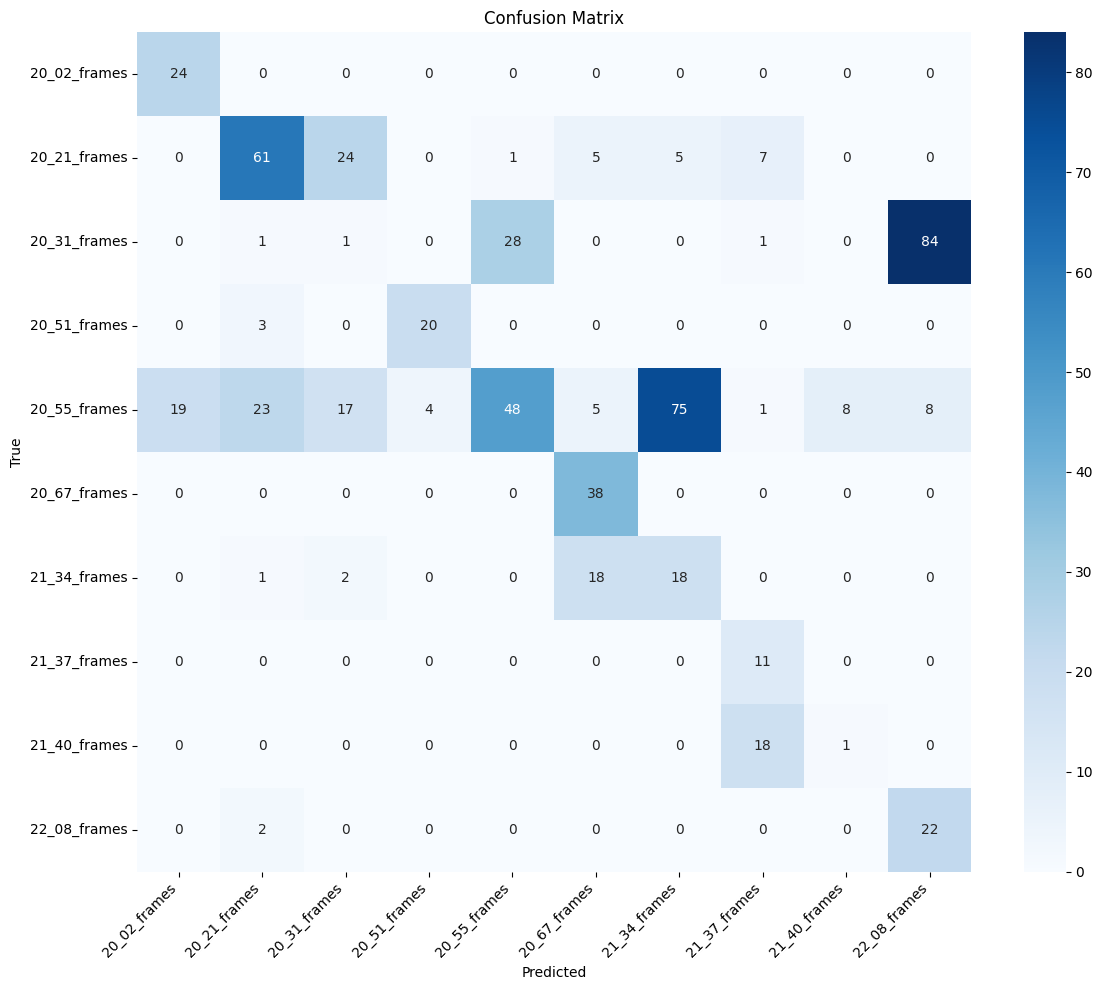

{'precision': 0.4517398995753505, 'recall': 0.40397350993377484, 'f1': 0.37254452122431164, 'accuracy': 0.40397350993377484, 'recall@k': {1: np.float64(0.40397350993377484), 3: np.float64(0.4735099337748344), 5: np.float64(0.5082781456953642)}}


In [ ]:
metrics = evaluate_model(
    test_folder=os.path.join(DATA_PATH, "test"),
    index=train_index,
    paths=train_paths,
    k_values=(1,3,5)
)
print(metrics)

### Всё, тестирование завершено

### Далее работа над семплером

Из-за дизбаланса классов, который нашел Кирилл, нам необходимо по разному работать с файлами которые пойдут в train для дообучения трансформера. мы хотим чтобы картинок каждого класса было одинакого, а значит в классах, где мало картинок каждую надо брать много раз. Из-за этого аугментация будет очень агрессивная, чтобы картинка была каждый раз разная

In [ ]:
jpg_counts

{'extracted_folder/Whale ReId 2/20_01_frames/crop1_DJI_0481': 28,
 'extracted_folder/Whale ReId 2/20_01_frames/crop_DJI_0001': 120,
 'extracted_folder/Whale ReId 2/20_01_frames/crop2_DJI_0481': 80,
 'extracted_folder/Whale ReId 2/20_01_frames/crop1_DJI_0002': 11,
 'extracted_folder/Whale ReId 2/20_01_frames/crop3_DJI_0002': 23,
 'extracted_folder/Whale ReId 2/20_01_frames/crop2_DJI_0002': 16,
 'extracted_folder/Whale ReId 2/20_01_frames/crop4_DJI_0002': 44,
 'extracted_folder/Whale ReId 2/20_01_frames/crop3_DJI_0481': 66}

In [ ]:
max_count = max(jpg_counts.values())
max_count

120

In [ ]:
# Определяем пороги
threshold_low = 0.25 * max_count
threshold_high = 0.75 * max_count

print("Пороги для аугментаций:")
print(f"Агрессивные: < {threshold_low}")
print(f"Умеренные: {threshold_low} - {threshold_high}")
print(f"Базовые: > {threshold_high}")

Пороги для аугментаций:
Агрессивные: < 30.0
Умеренные: 30.0 - 90.0
Базовые: > 90.0


Это был пример как мы будем определять пороги

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torchvision.datasets import ImageFolder

In [ ]:
transform_aggressive =

transform_medium =

transform_basic =

In [ ]:
class BalancedDataGenerator(Dataset):
    def __init__(self, dataset, class_counts, max_count, transform_aggressive, transform_moderate, transform_basic):
        self.dataset = dataset
        self.class_counts = class_counts
        self.max_count = max_count
        self.transform_aggressive = transform_aggressive
        self.transform_moderate = transform_moderate
        self.transform_basic = transform_basic

        self.class_to_images = defaultdict(list)
        for img_path, label in dataset.imgs:
            self.class_to_images[label].append(img_path)

    def __len__(self):
        return self.max_count * len(self.class_counts)

    def __getitem__(self, idx):
        class_idx = idx // self.max_count
        image_idx = idx % self.max_count

        label = list(self.class_counts.keys())[class_idx]
        images = self.class_to_images[label]

        if image_idx >= len(images):
            img_path = random.choice(images)
            image = Image.open(img_path).convert('RGB')
            if self.class_counts[label] < 0.25 * self.max_count:
                transform = self.transform_aggressive
            elif self.class_counts[label] < 0.75 * self.max_count:
                transform = self.transform_moderate
            else:
                transform = self.transform_basic

            image_np = np.array(image)
            augmented = transform(image=image_np)
            image = augmented['image']
        else:
            img_path = images[image_idx]
            image = Image.open(img_path).convert('RGB')
            image_np = np.array(image)
            augmented = self.transform_basic(image=image_np)
            image = augmented['image']

        return image, label

In [ ]:
root = "/content/extracted_folder/Whale ReId 2/20_01_frames"
dataset = ImageFolder(root=root)

class_counts = {}
for img_path, label in dataset.imgs:
    class_counts[label] = class_counts.get(label, 0) + 1

In [ ]:
balanced_dataset = BalancedDataGenerator(
    dataset=dataset,
    class_counts=class_counts,
    max_count=max(class_counts.values()),
    transform_aggressive=transform_aggressive,
    transform_moderate=transform_medium,
    transform_basic=transform_basic
)

len(balanced_dataset)

# Далее мы можем создать DataLoader
# dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

960